# Project: Fairness in Classification on the COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr

## PART 1 - Analysis of COMPAS dataset
we begin this project by analysing the dataset we will be working with.


In [94]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports
import urllib
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import torch
import math
import torch.nn.functional as F
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from pylab import rcParams
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split

<h1>1. Dataset exploration</h1>
In this part we will explore the ProPublica COMPAS dataset by determining the features available for exploration, labels. we will also analyse performance metrics according to race and gender available in the dataset. 
The main goal of this section is to determine and understand the features needed to build a classifier and determine if the COMPAS prediction was atually biased.

<h3>1. 1 ProPublica COMPAS dataset</h3>
we begin by either downloading or loading the dataset, and exploring its content.

In [95]:
#function to plot some graphs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

#downloading or checking for data
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

pd.options.display.max_columns = None
df=pd.read_csv('compas-scores-two-years.csv')
df

Looking for file '%s' in the current directory... compas-scores-two-years.csv
File found in current directory..


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

From the display of the datset above, we have 53 columns and 7214 rows.
Not all columns will be needed to analyse the data so we have to remove columns that will not be needed.To decide, we can display colummns having empty values to determine if they will have much much impact on the exploration or not.

In [96]:
#sum of null values per column
df.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

We can see from the data above, some columns such as r_case, r_charge_degree have a huge amount of empty values. We can't use these part of the data to build our classifier or do any analysis as it will be highly biased if those columns should have anything to do with prediction. Columns such as id and name will also not be needed to do our analysis because we will not need the name of the person to see how our classifier will perform in the next part.

<h3>1.2 Filtered Dataset</h3>
 We will first remove all columns which contain null (NaN) values, followed by listing each column with how many unique values they have.

In [97]:
#removing null values
df = df[df.columns[~df.isnull().any()]]
#unique valyes in each column
df.nunique()

id                       7214
name                     7158
first                    2800
last                     3950
compas_screening_date     690
sex                         2
dob                      5452
age                        65
age_cat                     3
race                        6
juv_fel_count              11
decile_score               10
juv_misd_count             10
juv_other_count            10
priors_count               37
c_charge_degree             2
is_recid                    2
is_violent_recid            2
type_of_assessment          1
decile_score.1             10
score_text                  3
screening_date            690
v_type_of_assessment        1
v_decile_score             10
v_score_text                3
v_screening_date          690
priors_count.1             37
start                     237
end                      1115
event                       2
two_year_recid              2
dtype: int64

By observing our result, some columns have large number of unique values. 
These may indicate that they are not highly relevant, which means we can drop them. We can also see there are some columns which only have 1 unique value, we will not use these data because we cant use it as a feature. It is same for everyone in the dataset.

According to our analysis, we select the following columns for exploration of the dataset. this totals up to 15 columns

In [98]:
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'is_recid', 
         'is_violent_recid', 'decile_score', 'score_text', 'v_decile_score', 'v_score_text', 'event', 'two_year_recid']]
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_recid,is_violent_recid,decile_score,score_text,v_decile_score,v_score_text,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,0,1,Low,1,Low,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,3,Low,1,Low,1,1
2,Male,Less than 25,African-American,0,0,4,F,1,0,4,Low,3,Low,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,0,8,High,6,Medium,0,0
4,Male,25 - 45,Other,0,0,2,F,0,0,1,Low,1,Low,0,0


In this section we begin to explore our dataset. how many race, how many people have prior crime counts, which race is mostly labelled as a risk, which age category is at a risk of being labelled high or low score.
## 1.3 Feature/ columnAnalysis
### 1.3.1 Race
we analyse counts per race

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

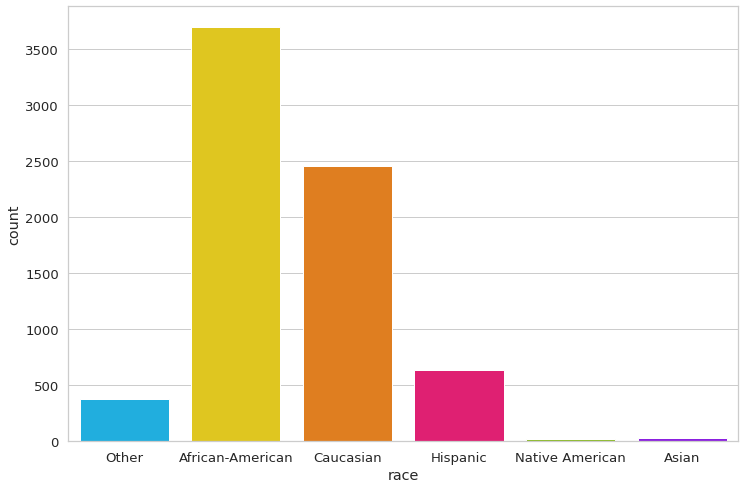

In [99]:
sns.countplot(df.race)
df.race.value_counts()

As shown above there are a total of 5 different race considered and other races labelled as "Other". African-Americans have the largest number of records followed by caucasians.we can also observe that the number of African-Americans will be almost equal to the total number of all other races combined.
races may have an effect on the result of classifier. 

we continue our analysis for other features.

### 1.3.2 Prior Counts
below we analysis the number of people having some prior counts of crimes.

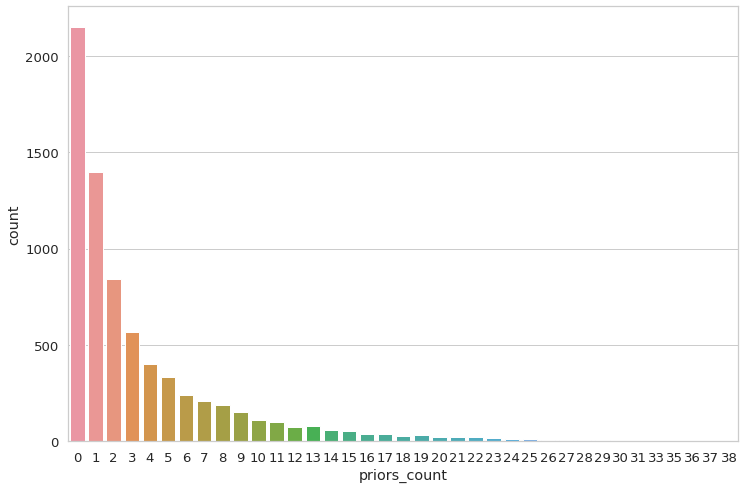

In [100]:
sns.countplot(df.priors_count)

prior_count shows how many times a number of people offended. We can see a significant number of people have no prior counts. We can take into consideration this column to access the risk of recidivism of an individual.

### 1.3.3 Two_year Recid
we also analyse this section by race, age categories and by gender to see the distribution.
This dataset includes information about whether or not the subject recidivated in the last 2 years, and so we can directly test the accuracy of the predictions. 

In [101]:
#number of people per recid
df.two_year_recid.value_counts()

0    3963
1    3251
Name: two_year_recid, dtype: int64

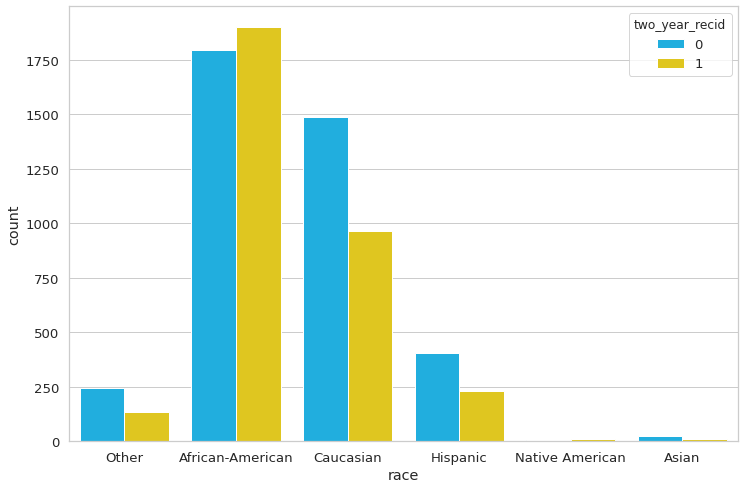

In [102]:
#Two_year Recid by race
by_race = sns.countplot(x="race", hue="two_year_recid", data=df[df.race.isin(['Caucasian','Asian','African-American', 'Hispanic','Native American', 'Other'])])

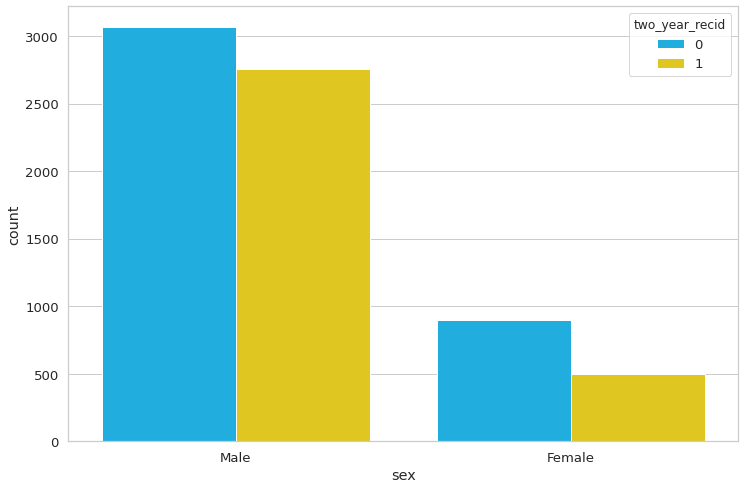

In [103]:
#Two_year Recid by sex
by_sex = sns.countplot(x="sex", hue="two_year_recid", data=df)


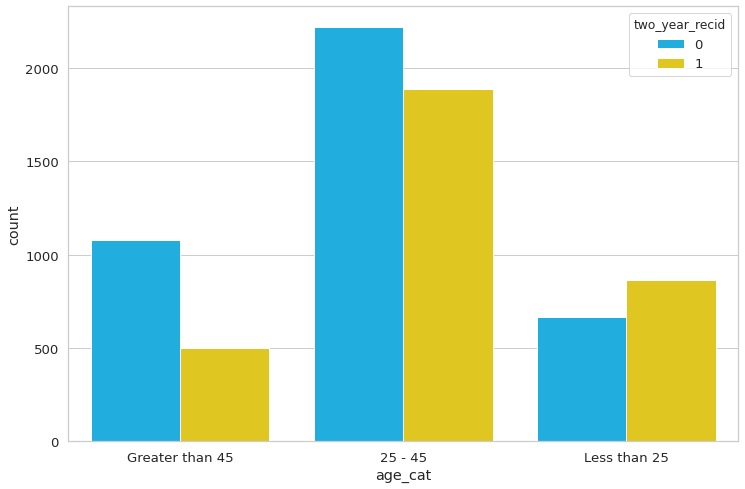

In [104]:
#Two_year Recid by age
by_age = sns.countplot(x="age_cat", hue="two_year_recid", data=df)

We can see from from graphs above give us the distribution of two_year Recid by by the various groups. The number of males and females with zero recid is higher than those with a number of recids. We can see by race that a significant number of African-Americans recidivated within the last two years as Compared to Caucasians. By age category, defendants greater than 45 years and those between 25-45 years have not committed a crime in the last two years as compared to categories of than 25 years.


### 1.3.4 Score_text
this is used to classify people into high, medium or Low category. These labels usually indicate how dangerous a particular person is. From compas, some people from a particular race were labelled with a high score_text while their offense does not merit such a label. Others were labelled as low or medium from a particular race even though their offense was one to be labelled high. Because of this label, the compass algorithm wrongly predicts redicivsm for a certain race. we would want to see the  distribution of people according to race in these score text.

Low       3897
Medium    1914
High      1403
Name: score_text, dtype: int64

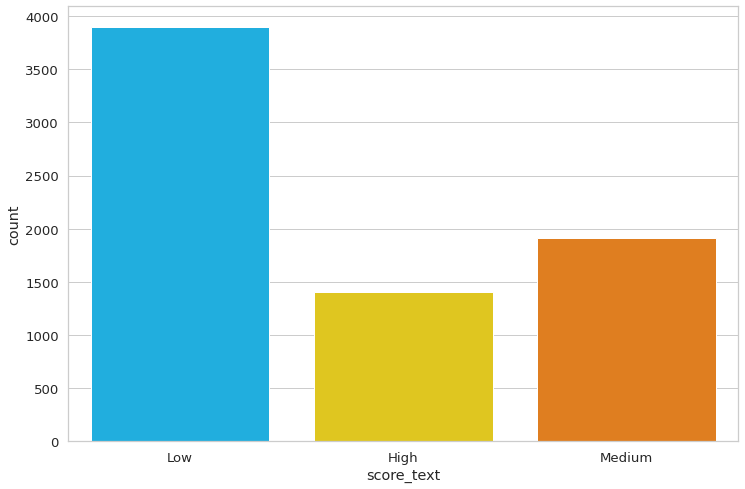

In [105]:
# number of people in each score_text
sns.countplot(df.score_text)
df.score_text.value_counts()

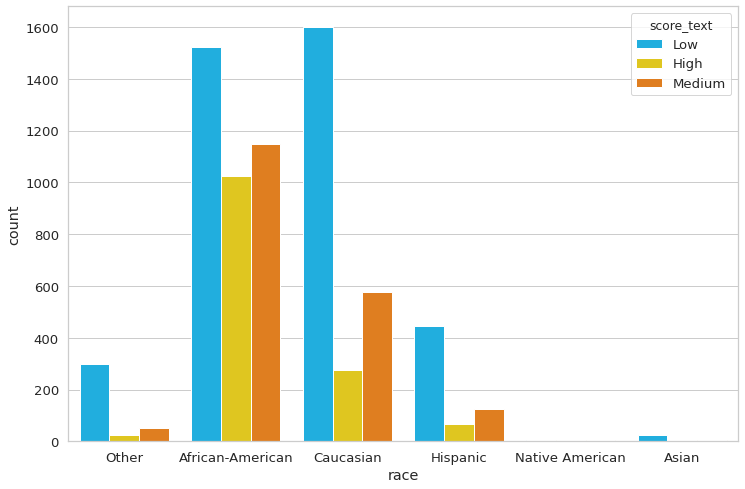

In [106]:
# number of people in each score_text by race
by_race = sns.countplot(x="race", hue="score_text", data=df[df.race.isin(['Caucasian','Asian','African-American', 'Hispanic','Native American', 'Other'])])

In the bar charts above, we see a large difference in how these scores are distributed by race, with a majority of Asians and Native-americans, others predicted as low risk (score = 0) and a majority of black people predicted high(score = 3) and medium risk (score = 2). Caucasians also have a majority predictes as high

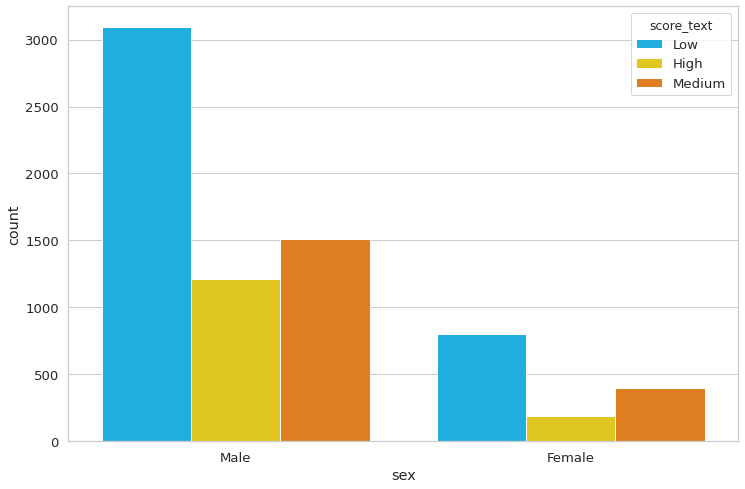

In [107]:
# number of people in each score_text by sex
by_sex = sns.countplot(x="sex", hue="score_text", data=df)

we can see from above that there is ahuge disparity between the genders. More of the males were classified as high risk as compared to females.this might be as a result of the variation in count between the genders but the distribution is not fair. This means a male offender is likely to be classified as high as compared to a female for the same crime.

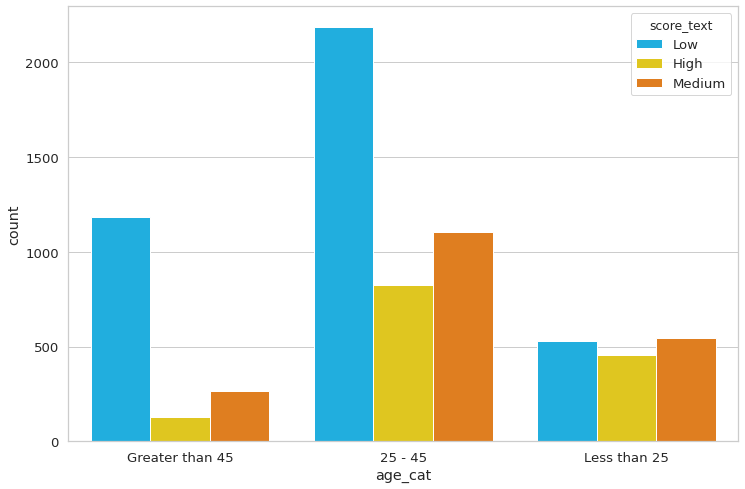

In [108]:
# number of people in each score_text by age category
by_age = sns.countplot(x="age_cat", hue="score_text", data=df)

From the graphs, the number of people labelled as medium and high is far less than the number of people labelled as low. BUt our anaysis from race shows that, majority of high and medium labels were African-Americans. Even Caucasian had the highest number of low labels.
In age category, we can see a significant number of high and medium labels were for defendants between 25-45 years. Less than 25 offenders are likely to be placed into any label as they have almost the same distribution and greater than 45 are mostly labelled as a low. This might be a discrimination by age category because the likely of placing a 50 year old defendent as low while his offense deserves a high is really high.

Without considering the prior count on the graphs above, we can see Caucasian, Hispanic, Asian and other have almost a similar ditribution, Native Americans have the same ditributions accross this labels and African-Americans have a higher distribution. It should be noted that the number of people (labelled as frequency in the graph) is not the same accross the races. African-Americans have the highest number of people in this dataset.

Judges are always presented with 2 labels (one that classifies people into High, Medium and Low risk, and a corresponding decile score). 

### 1.3.5 Decile_Scores (Risk scores)
the decile score ranges from 1 to 10 with 1 being the least probability to recidiviate and 10 being the highest.
below is a distribution of the decile scores according to the race categories


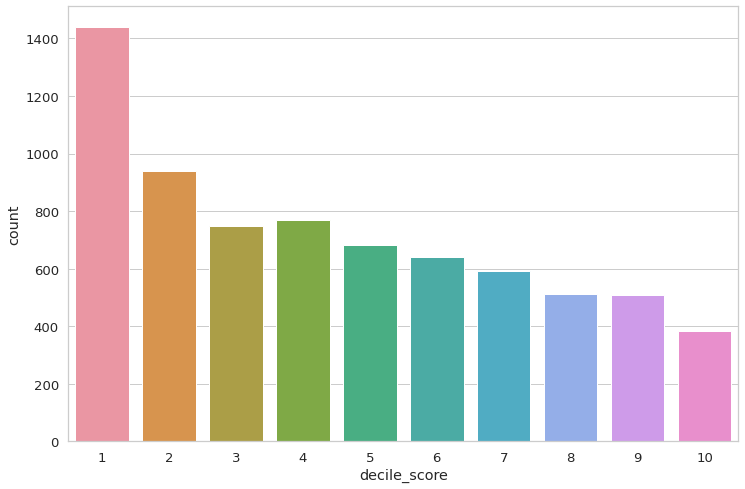

In [109]:
#number of people per decile_score
sns.countplot(df.decile_score)

The graph above shows the distribution of the number of people distibuted accorss the decile scores. This does not give a detailed information so we could continue to analyse by race.

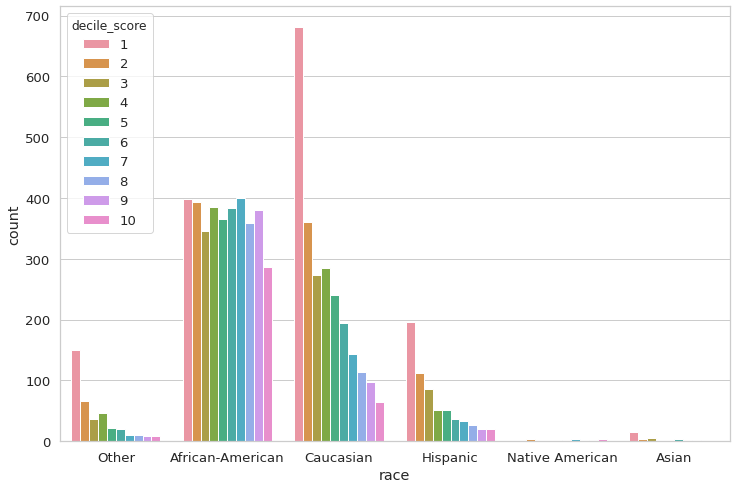

In [110]:
# decile score distribution by race
by_race = sns.countplot(x="race", hue="decile_score", data=df[df.race.isin(['Caucasian','Asian','African-American', 'Hispanic','Native American', 'Other'])])

'African-American' decile scores are almost evenly distributed. This means there is a higher chances of being classified as '8' or '10' for a crime deserving an '1'. if we look closely score of '0' and '7' is almost equal in african americans. this mentions a possibility as being mislabelled for an offense.

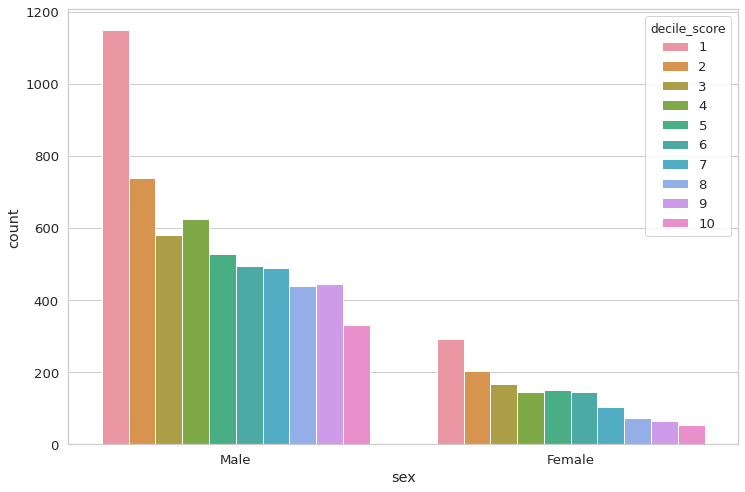

In [111]:
# decile score distribution by sex
by_sex = sns.countplot(x="sex", hue="decile_score", data=df)

Also by gender, males are likely to be given a higher score than females. In males the decile scores  equal in 6 and 7 have almost equal number of people, same for 8 and 9. Another possibility of being misclassified or mislabelled for crimes. For females, The score seems to be even from 3 to 6 so there is a possibility for a female to be laballed as any of these three.

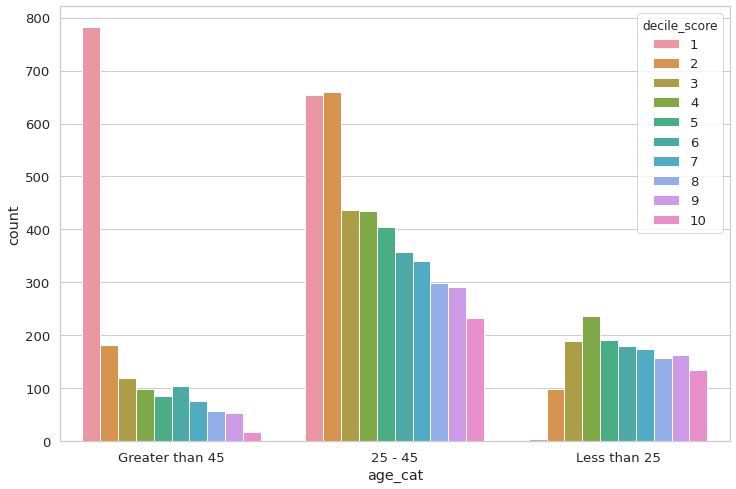

In [112]:
# decile score distribution by age category
by_age = sns.countplot(x="age_cat", hue="decile_score", data=df)

majority of the decile score was attributed to age category of 25-45. Less than age of 25, it is high to be classified as a 2,4,5,6,7,8 or 9 because the range seems to be almost equal. Majority of greater than 45 were classified as a 1 with few classified as a 10. this shows a bias against the age category of 25-45 and less than 25.

## 1.4 Compass Classifier and Performance Metrics
We will compute basic performance metrics of the COMPAS predictions in this section. As mentioned in the document, the main issue of this predictions is biased towards certain racial group.

According to COMPAS 'two_year_recid' is the ground truth which indocates whether the offenders actually recidivated or not. Therefore we can use this data to compute the accuracy of COMPAS prediction by considering value of 'score_text'. To simplify we will consider if the value of 'score_text' is 'High', it means that the classifer tells that the corresponding criminal will redivicate.<br><br>

Practically, we will first need to convert the column 'score_text' into 0 and 1 values. To simplify any 'Low' values in 'score_text' means that the compass classifier predicted the defendants to not recid (two_year_recid = 0). Then we will compute the accuracy, also other metrics such as Precision and Recall would be evaluated.

Accuracy	: 0.6537288605489326
              precision    recall  f1-score   support

           0       0.68      0.69      0.68      3897
           1       0.63      0.61      0.62      3317

    accuracy                           0.65      7214
   macro avg       0.65      0.65      0.65      7214
weighted avg       0.65      0.65      0.65      7214



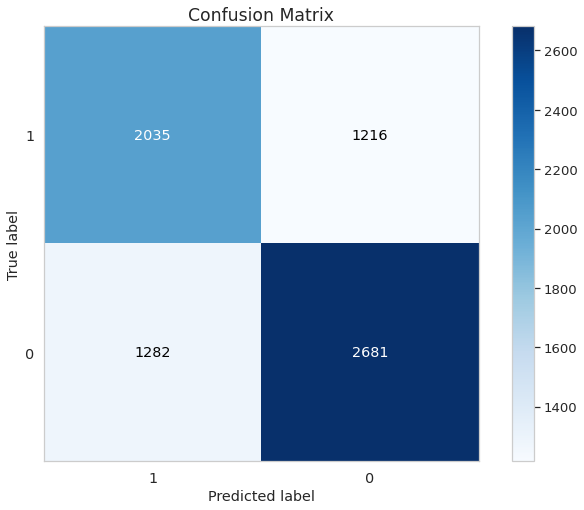

In [113]:
nparray = pd.DataFrame(df['score_text']).to_numpy()
nparray1 = pd.DataFrame(df['two_year_recid']).to_numpy()
i = 0
for x in nparray:
    if x == "Low":
        nparray[i] = 0
    else:
        nparray[i] = 1
    i = i + 1

y_pred = nparray.astype('int')
y_true = nparray1.astype('int')
print("Accuracy\t: " + str(accuracy_score(y_true, y_pred)))
print(classification_report(y_pred,y_true))
skplt.metrics.plot_confusion_matrix(y_true,y_pred, labels=[1,0])

We can see that all of the performance metric values are pretty low. The crowd based accuracy is at 65% with no race condition attached. This means not all cases were correctly classified. Precision is also based at 0.65 meaning that not all relevant instances used for the classification are not available. f1_score is the effectiveness of data classification.  it is a combination of precision and recall, best value is 1.

From the confusion matrix, we can see a greater portion of the data was misclassified from the prediction. there is a higher number of False-Negative as compared to False Positives. The number of false positives is too high. People are in this category have a higher rate of being convicted.

This indicates that the Compass prediction is poor.The factors we mentioned above might be responsible for these misclassifications.

To analyze further, we will compute the metrics for each race to see if the accuracy is evenly distributed.

In [114]:
#performance of COMPAS by race
tmpaccuracy = [0] * 6
tmpprecission = [0] * 6
tmprecall = [0] * 6
idx=0
races = df.race.unique()
for race in races:
    nparray = pd.DataFrame(df['score_text'].loc[df['race'] == race]).to_numpy()
    nparray1 = pd.DataFrame(df['two_year_recid'].loc[df['race'] == race]).to_numpy()
    i = 0
    for x in nparray:
        if x == "Low":
            nparray[i] = 0
        else:
            nparray[i] = 1
        i = i + 1
        
    y_pred = nparray.astype('int')
    y_true = nparray1.astype('int')
    print(race+" Offenders => ")
    print("Accuracy\t: " + str(accuracy_score(y_true, y_pred)))
    print("Precision\t: " + str(precision_score(y_true, y_pred)))
    print("Recall\t\t: " + str(recall_score(y_true, y_pred)) + "\n")
    tmpaccuracy[idx] = accuracy_score(y_true, y_pred)
    tmpprecission[idx] = precision_score(y_true, y_pred)
    tmprecall[idx] = recall_score(y_true, y_pred)
    idx = idx + 1

Other Offenders => 
Accuracy	: 0.6657824933687002
Precision	: 0.5443037974683544
Recall		: 0.3233082706766917

African-American Offenders => 
Accuracy	: 0.6382575757575758
Precision	: 0.6297148114075437
Recall		: 0.7201472908995266

Caucasian Offenders => 
Accuracy	: 0.6699266503667481
Precision	: 0.5913348946135831
Recall		: 0.5227743271221532

Hispanic Offenders => 
Accuracy	: 0.6609105180533752
Precision	: 0.5421052631578948
Recall		: 0.44396551724137934

Native American Offenders => 
Accuracy	: 0.7777777777777778
Precision	: 0.75
Recall		: 0.9

Asian Offenders => 
Accuracy	: 0.84375
Precision	: 0.75
Recall		: 0.6666666666666666



the performance metrics per race seems not to have a huge gap with respect to the general performance.

Participant accuracy is not significantly different for black defendants (63%) compared with Asians(84%) and Native Americans(77%). We can see African-Americans can easily be misclassified.
The scores obtained from above just itirates the fact that the predictions are not always correct and that compass most often misclassifies the criminals.

we show below the graphs of the results obtained from performance evaluation of COMPAS. Each of the graphs (accuracy, precision and recall) is plotted by race.


#### 1.4.2 Accuracy graph

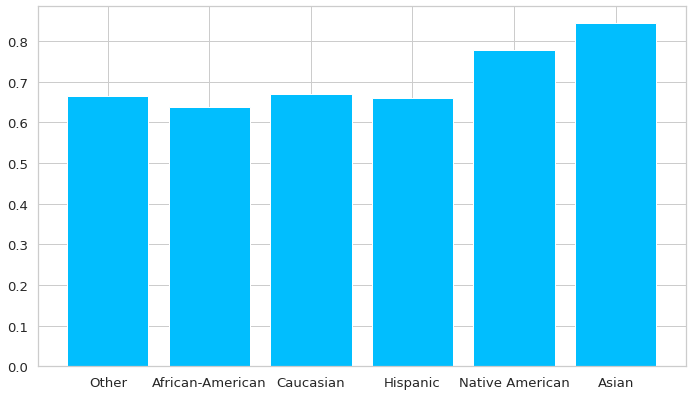

In [115]:
Race = df['race']
Race = Race.unique()
Accuracy = [tmpaccuracy[0], tmpaccuracy[1], tmpaccuracy[2], tmpaccuracy[3], tmpaccuracy[4], tmpaccuracy[5]]

fig = plt.figure()
fig.set_size_inches(9, 5)
ax = fig.add_axes([0,0,1,1])
ax.bar(Race,Accuracy)
plt.show()

the graph above is a representation of the accuracies obtained by race from COMPAS
#### 1.4.3  Precision & Recall Graph

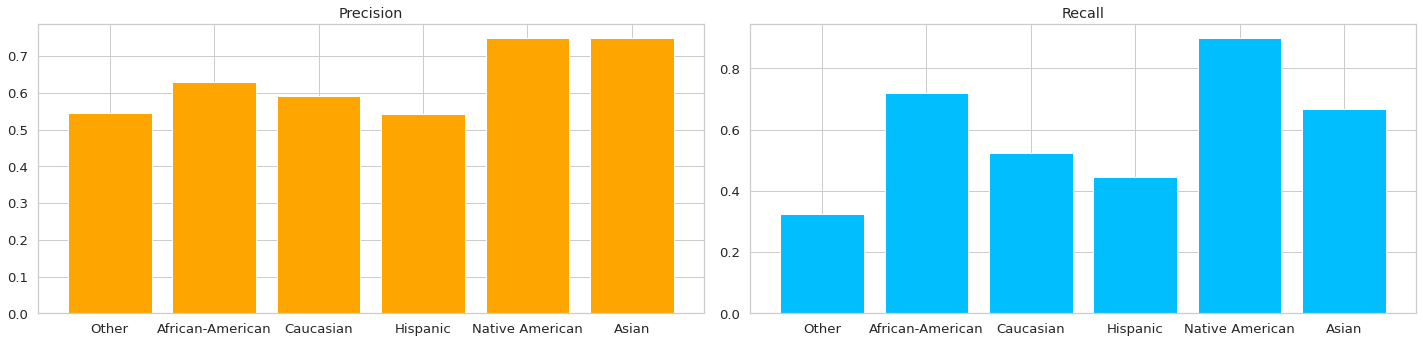

In [116]:
#Precision & Recall Graph
Precision = [tmpprecission[0], tmpprecission[1], tmpprecission[2], tmpprecission[3], tmpprecission[4], tmpprecission[5]]
Recall = [tmprecall[0], tmprecall[1], tmprecall[2], tmprecall[3], tmprecall[4], tmprecall[5]]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].set_title('Precision')
axes[0].bar(Race, Precision, color='orange')
axes[1].set_title('Recall')
axes[1].bar(Race, Recall)
fig.tight_layout()

from the precision and recall graphs, Precision is actually for Native-Americans and Asians, Recall also high for Native-Americans. we can say that the probability of mis predictiong an native american is not as significant as an african american.

###  1.5 Bias on Race
On the chart below we can see a graph based on the number of defendants by race where they labeled 'High' but didn't actually recid in two years. The next graph is showing the other way around, which is labeled 'Low' and 'two_year_recid' = 1.

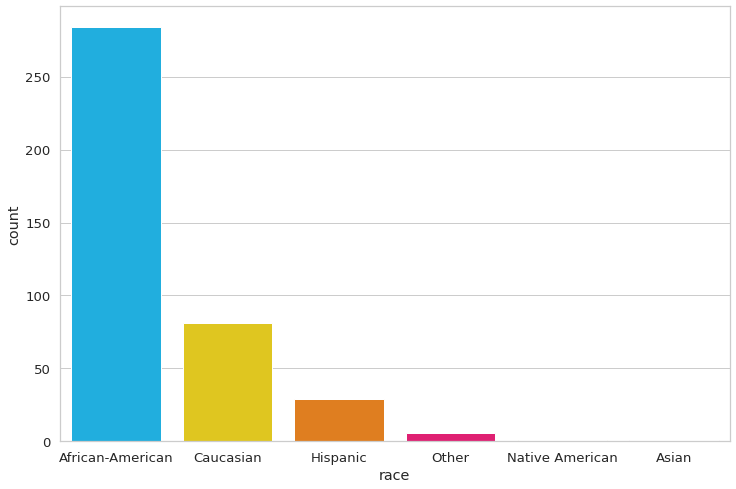

In [117]:
# no two year recid but labelled high by race
dfbias = df.loc[(df['two_year_recid']==0) & (df['score_text']=='High')]
sns.countplot(dfbias.race)

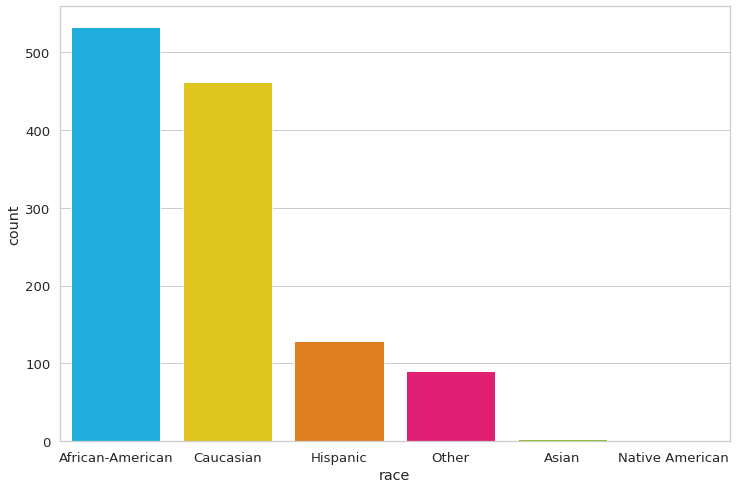

In [118]:
#has two year recid but labelled low by race
dfbias = df.loc[(df['two_year_recid']==1) & (df['score_text']=='Low')]
sns.countplot(dfbias.race)

From those two graph we can see that the most of the wrongly labeled defendants are 'African - American'. Other races which actually recided were labelled a low risk as compared to African-American.Also most of African-American who did not recid were labelled a high rish as compared to other races. This shows a bias in the race.

It is true that the proportion of 'African - American' defendant is much larger, however we can compute the percentage below. 

In [119]:
#bias values of two year recid by race
print("Bias for 'two_year_recid = 0' and score_text = 'High'")

total = len(df.loc[(df['race']=='African-American')])
zero_high = len(df.loc[(df['race']=='African-American') & (df['two_year_recid']==0) & (df['score_text']=='High')])
print("African-American\t = " + str(zero_high/total))

total = len(df.loc[(df['race']!='African-American')])
zero_high = len(df.loc[(df['race']!='African-American') & (df['two_year_recid']==0) & (df['score_text']=='High')])
print("Non African-American\t = " + str(zero_high/total))

print("\nBias for 'two_year_recid = 1' and score_text = 'Low'")

total = len(df.loc[(df['race']=='African-American')])
zero_high = len(df.loc[(df['race']=='African-American') & (df['two_year_recid']==1) & (df['score_text']=='Low')])
print("African-American\t = " + str(zero_high/total))

total = len(df.loc[(df['race']!='African-American')])
zero_high = len(df.loc[(df['race']!='African-American') & (df['two_year_recid']==1) & (df['score_text']=='Low')])
print("Non African-American\t = " + str(zero_high/total))

Bias for 'two_year_recid = 0' and score_text = 'High'
African-American	 = 0.07683982683982683
Non African-American	 = 0.033541785105173395

Bias for 'two_year_recid = 1' and score_text = 'Low'
African-American	 = 0.14393939393939395
Non African-American	 = 0.19442865264354747


As we can see from short computation above. There is definitely a bias towards 'African-American', since we have higher percentage compared to other races, when looking at the number of 'African-American' who labeled high but didn't recid. Also, lower percentage when they are actually recid but labeled 'Low'.




# PART 2 - Standard classifiers

<h2>2.1 Preprocessing </h2>
Before going further to building the classifiers, we will preprocess our data. First we select the needed columns and removing empty values.

In [28]:
df = df[df.columns[~df.isnull().any()]]
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


Next we need to convert string data into values/ numbers to be able to use it to train, test and predict.

In [29]:
#replacing strings with values
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


Next step is to divide our dataset. we divide the data into train and test set. we will use 0.2 percent of the training dataset as the test set. We also separate the features (X) and the ground truth (y).

In [32]:
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

<h2>2.2 Classifiers</h2>

In this part we will present different type of classifiers. The first goal is to compare them with the compas classifier in terms of overall performance, in this case we will the basic metrics such as accuracy, precision, and recall. Then we will observe and compare the fairness to the existing COMPAS classifier. we will use the following for classifiers;
   
        1. Logistic Regression
        2. Support Vector Machines
        3. Decision Tress
        3. K-nearest Neighbors
        5. Neural Networks

<h4>2.2.1. Logistic Regresssion</h4>
Logistic regression is used for prediction.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variables.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 


classification report 
               precision    recall  f1-score   support

    No Recid       0.89      0.97      0.93       823
       Recid       0.95      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9112959112959113


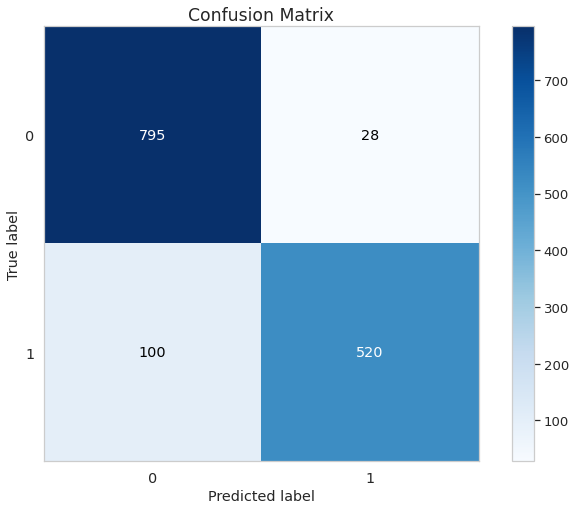

In [33]:
# Logistic Regression 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.values.ravel())
print (log_reg,'\n\n')

#prediction
y_pred = log_reg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

we can observe from the classification report that logistic regression performs well . Precision and recall is at 0.91 which is a good measurement considering the best has to be 1 to indicate that all predictions were correctly made.
Details can be view in the confusion matrix were true positives (520) and true negatives (795) have a higher values as compared to False positives (28) and False negatives(100).
This classifier performs well as compared to Compass predictions.

<h4>2.2.2. Support Vector Machine</h4>
Support vector machine algorithm is used to find hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points to get nearly accurate predictions.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 


classification report 
               precision    recall  f1-score   support

    No Recid       0.89      0.96      0.92       823
       Recid       0.94      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9106029106029107


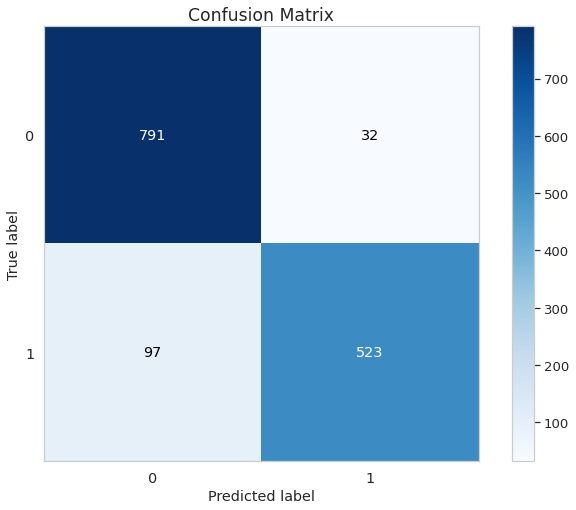

In [34]:
clfsvm = svm.SVC()
clfsvm.fit(X_train, y_train.values.ravel())
print (clfsvm,'\n\n')

#prediction
y_pred = clfsvm.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

we can see from the classification report that precision and recall stands at 0.91 which is a good indication of the classifier. We can say the performance is almost equal with logitic regression. Confusion matrix presents true positives (523) and true negatives (795) have a higher values as compared to False positives (32) and False negatives(97). comparing with Logistic regression, the predictions variations is very negligible. This classifier also performs better than COMPAS predictions.
2.2.3. Decision Tree Classifier ¶
Decision tres work more like an if-else consition. It split the data and continuously splits based on the features available .until it reaches the lowers point or a leaf.

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 


classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.93      0.90       823
       Recid       0.90      0.82      0.86       620

    accuracy                           0.88      1443
   macro avg       0.89      0.87      0.88      1443
weighted avg       0.88      0.88      0.88      1443

Overall Accuracy :  0.8828828828828829


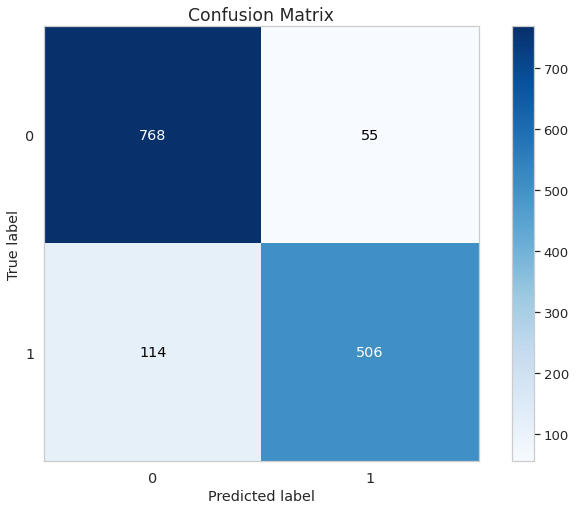

In [35]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print (clf,'\n\n')

#prediction
y_pred = clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " ,str(accuracy_score(y_test, y_pred)))


For decision trees, we can see our performance matrix have reduced to 0.88 as compared to SVM and logistic regression. One problem of decision trees is that it can create over-complex trees that do not generalize the data well for accurate predictions and also small variations in the data might result in a different tree being generated. This also affects the prediction.

But from above we can see that the performance metric is quite ok. the predictions are also not far from SVM and logistic regression. we have true positives (509) and true negatives (763) have a higher values as compared to False positives (60) and False negatives(111). This classifier also outperforms COMPAS predictions in this case.
2.2.4. K Nearest Neighbors 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform') 


classification report 
               precision    recall  f1-score   support

    No Recid       0.86      0.92      0.89       823
       Recid       0.88      0.80      0.84       620

    accuracy                           0.87      1443
   macro avg       0.87      0.86      0.86      1443
weighted avg       0.87      0.87      0.87      1443

Overall Accuracy :  0.8669438669438669


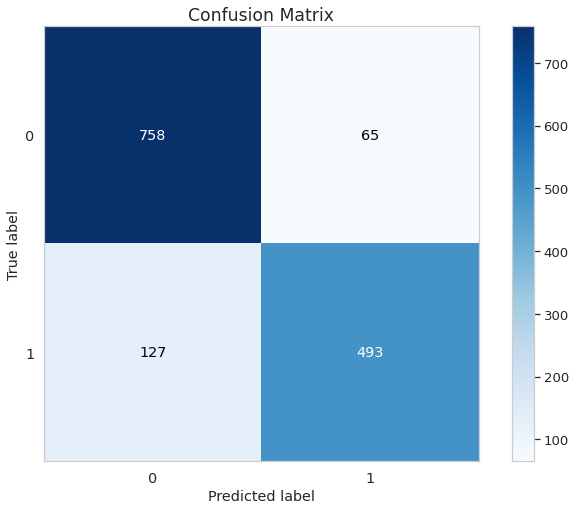

In [36]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.values.ravel())
print (neigh,'\n\n')

#prediction
y_pred = neigh.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

From the performance metrics, K nearest neighbours also performs less as compared to Logistic Regression and SVM. using this has increase the number of misclassifications as compared to Decision trees even though the accuracy is almost performance metric is almost same (0.87). we have true positives (493) and true negatives (758) have a higher values as compared to False positives (65) and False negatives(127).
2.2.5. Neural Network
In order to train the neural network we will have to split the data training again to get validation set. We then need to convert them into a tensor to be able to train and test with Pytorch.


In [39]:
#splitting the data
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# conversion to tensor
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_testnet = torch.from_numpy(X_test.to_numpy()).float()
y_testnet = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_testnet.shape) +", "+ str(y_testnet.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))

Training	 :torch.Size([4673, 10]), torch.Size([4673])
Testing		 :torch.Size([1443, 10]), torch.Size([1443])
Validation	 :torch.Size([520, 10]), torch.Size([520])


#### 2.2.5.1. First Model

Our first model will use simple architecture of neural network which has 3 convolutional layers. A batch size of 100, learning rate of 0.001

firstmodel(
  (fc1): Linear(in_features=8, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.722, Acc: 0.457 	|| Validation : - Loss: 0.716, Acc: 0.453
epoch {50} 	==> Train : - Loss: 0.35, Acc: 0.891 	|| Validation : - Loss: 0.313, Acc: 0.9
epoch {100} 	==> Train : - Loss: 0.331, Acc: 0.891 	|| Validation : - Loss: 0.304, Acc: 0.903
epoch {150} 	==> Train : - Loss: 0.327, Acc: 0.88 	|| Validation : - Loss: 0.302, Acc: 0.901
epoch {200} 	==> Train : - Loss: 0.326, Acc: 0.88 	|| Validation : - Loss: 0.301, Acc: 0.901
epoch {250} 	==> Train : - Loss: 0.325, Acc: 0.88 	|| Validation : - Loss: 0.301, Acc: 0.901
epoch {300} 	==> Train : - Loss: 0.325, Acc: 0.88 	|| Validation : - Loss: 0.301, Acc: 0.901
epoch {350} 	==> Train : - Loss: 0.325, Acc: 0.88 	|| Validation : - Loss: 0.3, Acc: 0.9

 classification report 
               precision    recall  f1-score   s

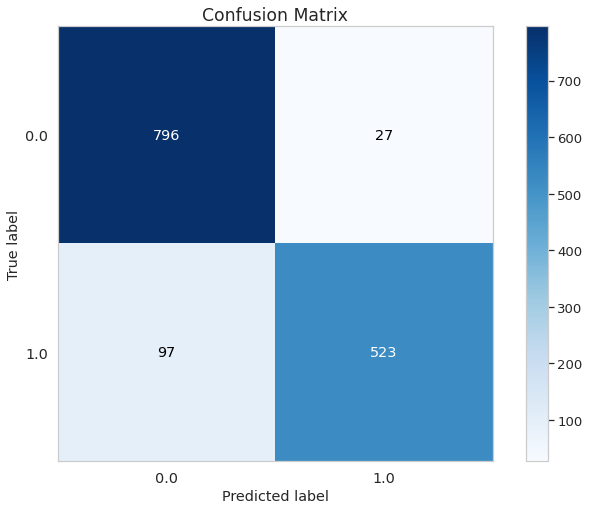

In [126]:
# Defining the model #1
class firstmodel(nn.Module):
  def __init__(self, n_features):
    super(firstmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net1 = firstmodel(X_train.shape[1])
print(net1)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net1(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net1(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net1(X_testnet)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_testnet = y_testnet.cpu()
print('\n classification report \n', classification_report(y_testnet, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_testnet, y_pred)

The performance metrics for this model stands at 0.92 which is a little improvement as compared to the previous classifiers. we have true positives (520) and true negatives (801) have a higher values as compared to False positives (22) and False negatives(100). This first neural network model also outperforms COMPAS predictions in this case.

### 2.2.5.2.Second model
In this model we added more layers and neurons. We also try to use different activation function(tanh).

secondmodel(
  (fc1): Linear(in_features=8, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.63, Acc: 0.609 	|| Validation : - Loss: 0.62, Acc: 0.666
epoch {50} 	==> Train : - Loss: 0.321, Acc: 0.891 	|| Validation : - Loss: 0.291, Acc: 0.898
epoch {100} 	==> Train : - Loss: 0.327, Acc: 0.891 	|| Validation : - Loss: 0.296, Acc: 0.901
epoch {150} 	==> Train : - Loss: 0.321, Acc: 0.891 	|| Validation : - Loss: 0.294, Acc: 0.9
epoch {200} 	==> Train : - Loss: 0.32, Acc: 0.88 	|| Validation : - Loss: 0.295, Acc: 0.9
epoch {250} 	==> Train : - Loss: 0.319, Acc: 0.88 	|| Validation : - Loss: 0.299, Acc: 0.898
epoch {300} 	==> Train : - Loss: 0.319, Acc: 0.88 	|| Validation : - Loss: 0.303, Acc: 0.898
epoch {350} 	==> Train : - Loss: 0.316, Acc: 0.891 	|| Validation : - Loss: 0.304, Acc: 0.896

 clas

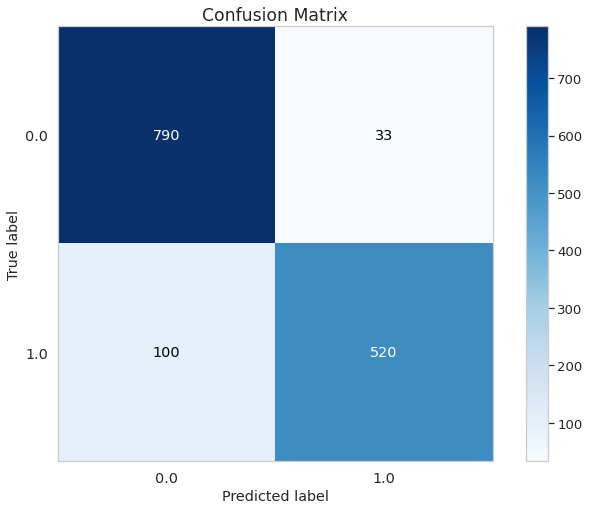

In [129]:
# Defining the model  #2
# Adding layers and neurons
class secondmodel(nn.Module):

  def __init__(self, n_features):
    super(secondmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 20)
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 10)
    self.fc4 = nn.Linear(10, 1)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

net2 = secondmodel(X_train.shape[1])
print(net2)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net2(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net2(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net2(X_testnet)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_testnet = y_testnet.cpu()
print('\n classification report \n', classification_report(y_testnet, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_testnet, y_pred)

from the two models described, we can see they perform almost equally but model 2 outperforms the first model by a difference in accuarcy of 0.003. there is also slight variation in the classifications based ont the confusion matrixes. we have true positives (527) and true negatives (793) have a higher values as compared to False positives (30) and False negatives(93) From both model, we can conclude that the performance is almost equal as the other classifiers we described above.

Model 2 outperforms model 1 looking as the confusion matrix values. Both models also outperform the COMPASS prediction.

Looking at the performance metrics of all our classifiers, they actually perform better compared to compass mode of prediction. We will recommend to use Logitic rgression, SVM or Neural networks to for the classification and prediction (based on the performances of our networks).
Conclusion on classifers based on accuracy

### Conclusion on classifers based on accuracy

/home/marck-edward/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


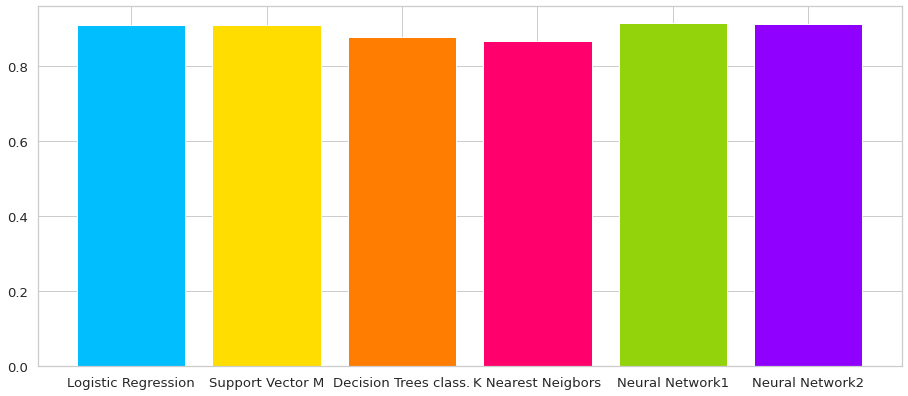

classifiers and their accuracies

Logistic Regression 		 0.9112959112959113
Support Vector M 		 0.9106029106029107
Decision Trees class. 		 0.8773388773388774
K Nearest Neigbors 		 0.8669438669438669
Neural Network1 		 0.9147609147609148
Neural Network2 		 0.9133749133749134


In [67]:
#accuracy graph of classifiers
ax = fig.add_axes([0,0,1,1])
bottom = ["Logistic Regression", "Support Vector M", "Decision Trees class.", "K Nearest Neigbors", "Neural Network1", "Neural Network2"]
class_accuracy = [0.9112959112959113, 0.9106029106029107, 0.8773388773388774, 0.8669438669438669
,0.9147609147609148,0.9133749133749134]
fig = plt.figure()
fig.set_size_inches(12, 5)
ax = fig.add_axes([0,0,1,1])
ax.bar(bottom,class_accuracy, color = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"])
plt.show()

print ('classifiers and their accuracies\n')
for (e1, e2) in zip(bottom, class_accuracy):
    print(e1, '\t\t' ,e2)


the figure above is a summary of the accuracies of the classifiers we defined.

## 2.3 Feature Sets
According to Probublica's Analysis, they use features including severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years to predict recidivism.

In our case we used the following for our prediction so far;
            
            sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 
         'c_charge_degree','is_violent_recid', 'v_decile_score', 'event','two_year_recid'

We want to determine in this section which features amongst our selected ones actually has an effect on the prediction. this will inform us the feature set that are really important to use in our subsequent sections.
for this section, we use use the logistic regression classifier we define above to determine the important feature  sets.

Our approach is to remove one feature set at a time and observe performance while maintaining our ground truth as 'two_year_recid'

In [49]:
dfnew = df
dfnew.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


<b>2.3.1.</b> Firstly, we remove 'v_decile_score' and 'is_violent_recid' from the features to analyse the performance

In [50]:
X_new = dfnew[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.88      0.96      0.92       823
       Recid       0.94      0.82      0.88       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.90      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


we can see from the classification report that removing 'v_decile_score' and 'is_violent_recid' from the feature set does not really affect the peformance of the classifier. Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91

<b>2.3.2.</b> In the next part we remove 'juv_fel_count' and 'c_charge_degree' in addition to the previously removed features to analyse the performance.

In [51]:
X_new = dfnew[['sex','age_cat', 'race', 'juv_misd_count', 'priors_count', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.97      0.92       823
       Recid       0.95      0.81      0.88       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9015939015939016


we can see from the classification report that removing 'juv_fel_count' and 'c_charge_degree' also does not have much effect on the peformance of the classifier. 
Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91. we still need to remove more features to determine the needed features.

<b>2.3.3.</b> in the next part we remove 'sex','age_cat'and 'juv_misd_count' in addition to previously removed features

In [52]:
X_new = dfnew[[ 'race', 'priors_count', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.97      0.92       823
       Recid       0.95      0.81      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.90      0.90      0.90      1443

Overall Accuracy :  0.8995148995148995


Again Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.89 as compared to the original set which gave us 0.91. Performance is actually still good in this regard. We still need to remove more features to determine the needed features.

<b>2.3.4.</b> in the next part we remove 'priors_count' 

In [53]:
X_new = dfnew[['race', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.98      0.92       823
       Recid       0.96      0.80      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


Again Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91. Performance is actually still good in this regard. We still need to remove more features to determine the needed features.

2.3.5. in the next part we remove 'event'


In [54]:
X_new = dfnew[[ 'race']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.56      0.93      0.70       823
       Recid       0.33      0.04      0.08       620

    accuracy                           0.55      1443
   macro avg       0.45      0.49      0.39      1443
weighted avg       0.46      0.55      0.43      1443

Overall Accuracy :  0.5509355509355509


we can see that removing event and only considering race, overall accuracy now stands at 0.55 which is pretty bad. This tells us that the 'event' feature is necessary to give us an accurate prediction

<b>2.3.6.</b> in the next part we remove 'race' 

In [55]:
#removing v_decile_score, is violent recid, c_charge_degree, juv_misd_count, juv_fel_count, age_cat, prior_count, sex
X_new = dfnew[[ 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_trainfs, X_testfs, y_trainfs, y_testfs = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_trainfs, y_trainfs.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_predfs = log_reg_new.predict(X_testfs)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_testfs, y_predfs, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_testfs, y_predfs)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.98      0.92       823
       Recid       0.96      0.80      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


we can see that using the 'event' set alone gives us a good accuracy of 0.90. we can now conclude that event is one of the feature sets necessary for correct prediction.
using event alone gives us the same accuracy as using 'event' and 'race' feature

### Features to Use
##### not sure - From our analysis, we recommend using the 'event' in addition to any other feature set for the classification or prediction to be almost accurate.
## 2.4 Fairness
We will investigate the fairness of each classifier with the notion of Independence and seperation.

###  Independence
According to the book. To satisfy independence simply requires that the sensitive characteristic to be statistically independent of the scores recorded. Independence condition requires the acceptance rate to be the same in all groups to be considered.

###  Seperation
Separation allows correlation between the score and the sensitive attribute to the extent that it is justified by the target variable.

Since race is a sensitive feature, we will observe independence for particularly 'African-American' compared to all other races. we will use all our predifined classifiers to observe this notion of fairness. We will also observe this on gender as well.

Therefore first we will have to filter the dataframe according to race and sex.

In [56]:
# filtering according to African-American
Xfair1 = X_test.loc[df['race'] == 2]
yfair1 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]

Xfair2 = X_test.loc[df['race'] != 2]
yfair2 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]

# filtering according to sex
Xfair3 = X_test.loc[df['sex'] == 1]
yfair3 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]

Xfair4 = X_test.loc[df['sex'] == 2]
yfair4 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]

#### 2.4.1 Logistic Regression

In [57]:
print(">> Race ===>")
y_pred = log_reg.predict(Xfair1)
#relabelling confusion matrix and calculating tpr and fpr
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0]) 
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = log_reg.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

#independence ratio
independence1 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence1 = Pfair2_true/Pfair1_true

#tpr and fpr ratio according to seperation  
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf1r = fpr1/fpr2
if sepf1r>1:
    sepf1r = fpr2/fpr1
    
print("-- Independence (Ratio) \t\t = " + str(round(independence1,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf1r,3)) )


print("\n>> Gender ===>")
y_pred = log_reg.predict(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = log_reg.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence1g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence1g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf1g = fpr1/fpr2
if sepf1g>1:
    sepf1g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence1g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf1g,3)) )

>> Race ===>
- African-American =>
True Positive Rate	 = 0.8387096774193549
False Positive Rate	 = 0.052924791086350974
Acceptance rate		 = 0.4528043775649795
- Non African-American =>
True Positive Rate	 = 0.8387096774193549
False Positive Rate	 = 0.01939655172413793
Acceptance rate		 = 0.3047752808988764
-- Independence (Ratio) 		 = 0.673
-- Separation (TPR Ratio) 	 = 1.0
-- Separation (FPR Ratio) 	 = 0.366

>> Gender ===>
- Males =>
True Positive Rate	 = 0.8429906542056075
False Positive Rate	 = 0.0364741641337386
Acceptance rate		 = 0.39815590947191953
- Females =>
True Positive Rate	 = 0.8117647058823529
False Positive Rate	 = 0.024242424242424242
Acceptance rate		 = 0.292
-- Independence (Ratio) 	 = 0.733
-- Separation (TPR Ratio) 	 = 0.963
-- Separation (FPR Ratio) 	 = 0.665


using Logistic regression, the false positive ratio for race is 0.3 which is not that bad and according to gender its a little high at 0.66. The true positive value is 1 and 0.96 in race and gender respectively, a good indication of fairness. Independence ratio is almost close in gender and race.

#### 2.4.2 Support Vector Machine

In [58]:
print(">> Race ===>")
y_pred = clfsvm.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clfsvm.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence2 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence2 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf2r = fpr1/fpr2
if sepf2r>1:
    sepf2r = fpr2/fpr1
    
print("-- Independence (Ratio) \t\t = " + str(round(independence2,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf2r,3)) )


print("\n>> Gender ===>")
y_pred = clfsvm.predict(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clfsvm.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence2g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence2g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf2g = fpr1/fpr2
if sepf2g>1:
    sepf2g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence2g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf2g,3)) )


>> Race ===>
- African-American =>
True Positive Rate	 = 0.8440860215053764
False Positive Rate	 = 0.0584958217270195
Acceptance rate		 = 0.4582763337893297
- Non African-American =>
True Positive Rate	 = 0.842741935483871
False Positive Rate	 = 0.023706896551724137
Acceptance rate		 = 0.3089887640449438
-- Independence (Ratio) 		 = 0.674
-- Separation (TPR Ratio) 	 = 0.998
-- Separation (FPR Ratio) 	 = 0.405

>> Gender ===>
- Males =>
True Positive Rate	 = 0.8485981308411215
False Positive Rate	 = 0.0425531914893617
Acceptance rate		 = 0.40402347024308466
- Females =>
True Positive Rate	 = 0.8117647058823529
False Positive Rate	 = 0.024242424242424242
Acceptance rate		 = 0.292
-- Independence (Ratio) 	 = 0.723
-- Separation (TPR Ratio) 	 = 0.957
-- Separation (FPR Ratio) 	 = 0.57


using Support Vector Machine, the false positive ratio for race is 0.4  and according to gender its a little high at 0.57 which is a reduction from the logistic regression classifier. The true positive value is 0.99 and 0.95 in race and gender respectively which is quite good. Independence ratio also differs between race and gender by 0.1.

#### 2.4.3 Decision Trees

In [59]:
print(">> Race ===>")
y_pred = clf.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clf.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence3 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence3 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf3r = fpr1/fpr2
if sepf3r>1:
    sepf3r = fpr2/fpr1
    
print("-- Independence (Ratio) \t\t = " + str(round(independence3,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf3r,3)) )



print("\n>>Gender ===>")
y_pred = clf.predict(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = clf.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence3g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence3g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf3g = fpr1/fpr2
if sepf3g>1:
    sepf3g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence3g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf3g,3)) )


>> Race ===>
- African-American =>
True Positive Rate	 = 0.8279569892473119
False Positive Rate	 = 0.08635097493036212
Acceptance rate		 = 0.4637482900136799
- Non African-American =>
True Positive Rate	 = 0.7983870967741935
False Positive Rate	 = 0.05172413793103448
Acceptance rate		 = 0.31179775280898875
-- Independence (Ratio) 		 = 0.672
-- Separation (TPR Ratio) 	 = 0.964
-- Separation (FPR Ratio) 	 = 0.599

>>Gender ===>
- Males =>
True Positive Rate	 = 0.8205607476635514
False Positive Rate	 = 0.0668693009118541
Acceptance rate		 = 0.40486169321039395
- Females =>
True Positive Rate	 = 0.788235294117647
False Positive Rate	 = 0.06666666666666667
Acceptance rate		 = 0.312
-- Independence (Ratio) 	 = 0.771
-- Separation (TPR Ratio) 	 = 0.961
-- Separation (FPR Ratio) 	 = 0.997


Considering Decision trees classifier, the false positive ratio for race is 0.7 and according to gender is 0.64 which are both actually high. 

#### 2.4.4 K Nearest Neighbors

In [60]:
print(">> Race ===>")
y_pred = neigh.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = neigh.predict(Xfair2)
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence4 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence4 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf4r = fpr1/fpr2
if sepf4r>1:
    sepf4r = fpr2/fpr1
    
print("-- Independence (Ratio) \t\t = " + str(round(independence4,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf4r,3)) )


print("\n>>Gender ===>")
y_pred = neigh.predict(Xfair3)
Pfair3_true = np.sum(y_pred) / len(Xfair3)
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

y_pred = neigh.predict(Xfair4)
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(Xfair4)
print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence4g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence4g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf4g = fpr1/fpr2
if sepf4g>1:
    sepf4g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence4g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf4g,3)) )


>> Race ===>
- African-American =>
True Positive Rate	 = 0.8010752688172043
False Positive Rate	 = 0.10863509749303621
Acceptance rate		 = 0.46101231190150477
- Non African-American =>
True Positive Rate	 = 0.7862903225806451
False Positive Rate	 = 0.05603448275862069
Acceptance rate		 = 0.3103932584269663
-- Independence (Ratio) 		 = 0.673
-- Separation (TPR Ratio) 	 = 0.982
-- Separation (FPR Ratio) 	 = 0.516

>>Gender ===>
- Males =>
True Positive Rate	 = 0.8037383177570093
False Positive Rate	 = 0.08662613981762918
Acceptance rate		 = 0.4082145850796312
- Females =>
True Positive Rate	 = 0.7411764705882353
False Positive Rate	 = 0.048484848484848485
Acceptance rate		 = 0.284
-- Independence (Ratio) 	 = 0.696
-- Separation (TPR Ratio) 	 = 0.922
-- Separation (FPR Ratio) 	 = 0.56


In K Nearest Neighbors, the false positive ratio in both race and gender is almost equal but the value is not good. Meaning a significant number of people can still be wrongly convicted. but it performs well on the true-positive rate.
#### 2.4.5 Neural Network

In [61]:
print(">> Race ===>")
Xfair1net = torch.from_numpy(Xfair1.to_numpy()).float()
y_pred = net(Xfair1net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair2net = torch.from_numpy(Xfair2.to_numpy()).float()
y_pred = net(Xfair2net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/ len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5 = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf5r = fpr1/fpr2
if sepf5r>1:
    sepf5r = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5r,3)) )


print("\n>>Gender ===>")
Xfair3net = torch.from_numpy(Xfair3.to_numpy()).float()
y_pred = net(Xfair3net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0]) / len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair4net = torch.from_numpy(Xfair4.to_numpy()).float()
y_pred = net(Xfair4net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0]) / len(Xfair4)

print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5g = Pfair2_true/Pfair1_true
    
sept1 = tpr1/tpr2
if sept1>1:
    sept1 = tpr2/tpr1
sepf5g = fpr1/fpr2
if sepf5g>1:
    sepf5g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5g,3)) )

>> Race ===>
- African-American =>
True Positive Rate	 = 0.8548387096774194
False Positive Rate	 = 0.07520891364902507
Acceptance rate		 = 0.4719562243502052
- Non African-American =>
True Positive Rate	 = 0.8508064516129032
False Positive Rate	 = 0.03017241379310345
Acceptance rate		 = 0.3160112359550562
-- Independence (Ratio) 	 = 0.67
-- Separation (TPR Ratio) 	 = 0.995
-- Separation (FPR Ratio) 	 = 0.401

>>Gender ===>
- Males =>
True Positive Rate	 = 0.8548387096774194
False Positive Rate	 = 0.07520891364902507
Acceptance rate		 = 0.4165968147527242
- Females =>
True Positive Rate	 = 0.8117647058823529
False Positive Rate	 = 0.024242424242424242
Acceptance rate		 = 0.292
-- Independence (Ratio) 	 = 0.701
-- Separation (TPR Ratio) 	 = 0.95
-- Separation (FPR Ratio) 	 = 0.322


### 2.4.6 Conclusions on Independence and FPR according to race and sex

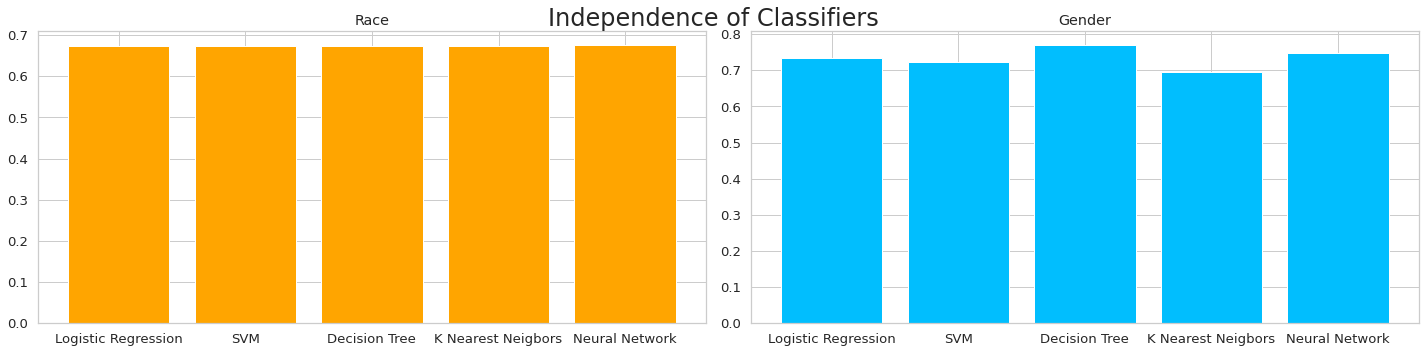

In [93]:
#Independence Representation from classifiers
bottom = ["Logistic Regression", "SVM", "Decision Tree", "K Nearest Neigbors", "Neural Network"]
left = [independence1, independence2, independence3, independence4, independence5]
leftg = [independence1g, independence2g, independence3g, independence4g, independence5g]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('Independence of Classifiers', fontsize=24)
axes[0].set_title('Race')
axes[0].bar(bottom, left, color='orange')
axes[1].set_title('Gender')
axes[1].bar(bottom, leftg)
fig.tight_layout()


As we can see from the result above there is not much difference between classifiers. We will consider the best one and combine the results on performance analysis, and the feature sets.

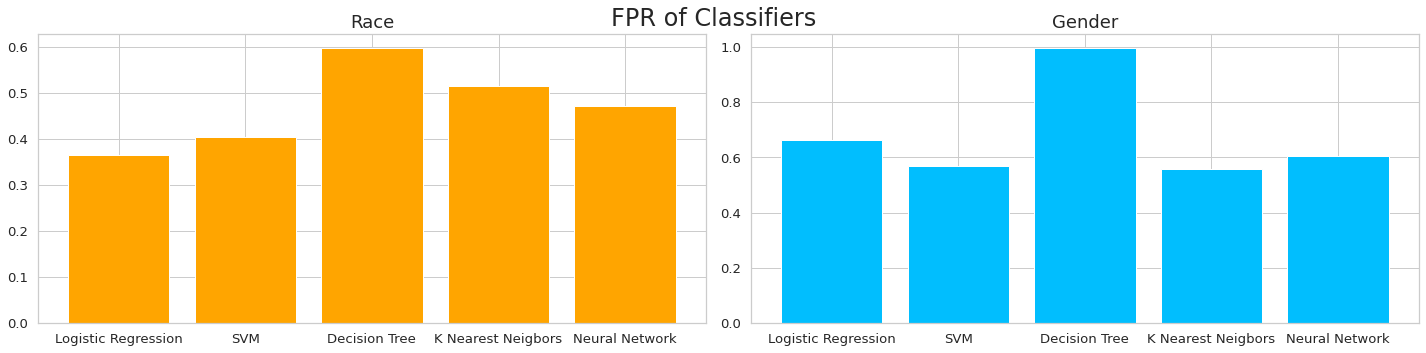

In [92]:
#FPR Representation from classifiers
bottom = ["Logistic Regression", "SVM", "Decision Tree", "K Nearest Neigbors", "Neural Network"]
RaceFP = [sepf1r, sepf2r, sepf3r, sepf4r, sepf5r]
GenderFP = [sepf1g, sepf2g, sepf3g, sepf4g, sepf5g]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.suptitle('FPR of Classifiers', fontsize=24)
axes[0].set_title('Race',fontsize=18)
axes[0].bar(bottom, RaceFP, color='orange')
axes[1].set_title('Gender', fontsize=18)
axes[1].bar(bottom, GenderFP)
fig.tight_layout()

# PART 3 - Fair classifiers


## 3.1 Fair Classifier
Machine Learning or data analysis which is one of the most used AI techniques relies heavily on data and this data can be biased because it is provided by humans. such is the case for our case study "COMPASS Dataset". Most of the data provided as seen in our analysis in part 1 is highly biased against African- Americans being by gender or age category. African-American defendants were more vulnerable to be incorrectly labeled as higher-risk than they actually were when compared to their white defendants.

### 3.1.1 How to Achieve Fairness
1. Pre-processing

We decided to remove the sensitive features 'race' and 'gender' to build our classifier, expecting we will get better fairness.
2. Training Time

Since we will use neural network we can adjust hyperparameters such that we will get good results both on performance and fairness.
3. Post-Processing

In this problem we will not perform any post-processing because to derive a classifier is too complex of a task.


### 3.1.2 Criterias
There has been some proposal on achieving fairness on a dataset for classification or prediction. Most of these fairness criterias are based on the some of the following criterias;

          
           1.Demographic Parity / Independence
           2.Equalized odds / Seperation
           
#### 1. Independence
This refers to the notion that decision rates of the people involved in anything from the two different group must be equal. such groups can be race, gender, age category as seen from compass. In this part we will observe the independence by computing the acceptance ratio of two groups 'African-America' and 'Non African-American', then another two groups of gender 'Male' and 'Female'. 

#### 2. Separation
Separation and independence are mutually exclusive, because separation accept the probability of sensitive features correlated with the target values.  Separation can be achieved when two different groups have relatively the same true positive rate and the same false positive rate. In this part we will focused on the ratio of FPR both for 'race' and 'gender'.

Based on the observation we did in the second part we will now build our own classifier which will hopefully performed better in terms of accuracy and fairness.

##### - Type of Classifier : Neural Network
We choose neural network since it performed quite well compared to other classifiers, when trying different type of classifiers. Another reason is the possibilty of adjusting the hyperparameters of the network, and possibly the architecture to get better result.

##### - Features :
To increase fairness in our classifier we will remove the columns 'race' and 'sex'. We have seen on previously in Feature set that these two features do not necessarily affect the overall performance. Thus we expect by removing them we will gain fairness and still obtain good overall performance. 

## 3.2 Evaluation

To evaluate the classifiers we have built we will compute some metrics based on our first neural network model, and then compare them with COMPAS classifier. As usual, the data we are using in here is testing data. This data will be used to get prediction results using our new classifier and compas classifier.

In [130]:
df=pd.read_csv('compas-scores-two-years.csv')

# preparing data by selecting needed colums and removing empty values
df = df[['race','sex', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid','score_text']]
df = df.dropna(how='any')

# Replace text with numbers
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['score_text'].replace({'Low': 0, 'Medium': 1, 'High' : 1}, inplace = True)

#splitting and converting data to tensor
X = df[['age_cat', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth

# Arrange the data : Training, Testing, Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# X_train.astype(dtype = 'float32')
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_testnet = torch.from_numpy(X_test.to_numpy()).float()
y_testnet = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_testnet.shape) +", "+ str(y_testnet.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))


Training	 :torch.Size([5193, 8]), torch.Size([5193])
Testing		 :torch.Size([1443, 8]), torch.Size([1443])
Validation	 :torch.Size([578, 8]), torch.Size([578])


as stated earlier, we will use our second neural network (net2) defined in part 2 of the project to analyse the acceptance rate and FPR.

In [132]:
# filtering according to African-American
Xfair1 = X_test.loc[df['race'] == 2]
yfair1 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]

Xfair2 = X_test.loc[df['race'] != 2]
yfair2 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]

# filtering according to sex
Xfair3 = X_test.loc[df['sex'] == 1]
yfair3 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]

Xfair4 = X_test.loc[df['sex'] == 2]
yfair4 = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]

#according to race
y_pred = net2(X_testnet)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_testnet = y_testnet.cpu()
newacc = accuracy_score(y_testnet, y_pred)
newpre = precision_score(y_testnet, y_pred)
newrec = recall_score(y_testnet, y_pred)
print("===> Performance")
print(">> Accuracy\t: " + str(accuracy_score(y_testnet, y_pred)))
print(">> Precision\t: " + str(precision_score(y_testnet, y_pred)))
print(">> Recall\t: " + str(recall_score(y_testnet, y_pred)))
print("\n===> Fairness");
print(">> Race ===>")
Xfair1net = torch.from_numpy(Xfair1.to_numpy()).float()
y_pred = net2(Xfair1net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair1, y_pred, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(Xfair1)
print("- African-American =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair2net = torch.from_numpy(Xfair2.to_numpy()).float()
y_pred = net2(Xfair2net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair2, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/ len(Xfair2)
print("- Non African-American =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5 = Pfair2_true/Pfair1_true
    
sept1n = tpr1/tpr2
if sept1n>1:
    sept1n = tpr2/tpr1
sepf5r = fpr1/fpr2
if sepf5r>1:
    sepf5r = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1n,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5r,3)) )

#according to gender
print("\n>> Gender ===>")
Xfair3net = torch.from_numpy(Xfair3.to_numpy()).float()
y_pred = net2(Xfair3net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair3, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0]) / len(Xfair3)
print("- Males =>")
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

Xfair4net = torch.from_numpy(Xfair4.to_numpy()).float()
y_pred = net2(Xfair4net)
y_pred = y_pred.ge(.5).view(-1).cpu()
row1, row2 = confusion_matrix(yfair4, y_pred, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0]) / len(Xfair4)

print("- Females =>")
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independence5g = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5g = Pfair2_true/Pfair1_true
    
sept2n = tpr1/tpr2
if sept2n>1:
    sept2n = tpr2/tpr1
sepf5g = fpr1/fpr2
if sepf5g>1:
    sepf5g = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independence5g,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept2n,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5g,3)) )


===> Performance
>> Accuracy	: 0.9078309078309078
>> Precision	: 0.9403254972875226
>> Recall	: 0.8387096774193549

===> Fairness
>> Race ===>
- African-American =>
True Positive Rate	 = 0.8360215053763441
False Positive Rate	 = 0.06128133704735376
Acceptance rate		 = 0.45554035567715456
- Non African-American =>
True Positive Rate	 = 0.842741935483871
False Positive Rate	 = 0.023706896551724137
Acceptance rate		 = 0.3089887640449438
-- Independence (Ratio) 	 = 0.678
-- Separation (TPR Ratio) 	 = 0.992
-- Separation (FPR Ratio) 	 = 0.387

>> Gender ===>
- Males =>
True Positive Rate	 = 0.8360215053763441
False Positive Rate	 = 0.06128133704735376
Acceptance rate		 = 0.40150880134115674
- Females =>
True Positive Rate	 = 0.8117647058823529
False Positive Rate	 = 0.030303030303030304
Acceptance rate		 = 0.296
-- Independence (Ratio) 	 = 0.737
-- Separation (TPR Ratio) 	 = 0.971
-- Separation (FPR Ratio) 	 = 0.494


Acceptance ratio between between male and females is quite close enough to realize fairness. Same in Race between African Americans and Non-African Americans. We are achieving fairness even though they are not the same value. The FPR ratios also seem to correlate.but they hav low values which is not a good measure of a fair classifier .

Below, we want to measure fairness also based on the ground truth used throughout the project (two_year_recid) and using score_text feature in addition to gender filtering and race.

In [133]:
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :]

comacc = accuracy_score(y_true, y_compas)
compre = precision_score(y_true, y_compas)
comrec = recall_score(y_true, y_compas)
print("===> Performance")
print(">> Accuracy\t: " + str(accuracy_score(y_true, y_compas)))
print(">> Precision\t: " + str(precision_score(y_true, y_compas)))
print(">> Recall\t: " + str(recall_score(y_true, y_compas)))

print("\n===> Fairness")
print(">> Race ===>")
print("- African-American =>")
#filtering on race
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']==2)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

print("- Non African-American =>")
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['race']!=2)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independencec = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independencec = Pfair2_true/Pfair1_true
    
sept1c = tpr1/tpr2
if sept1c>1:
    sept1c = tpr2/tpr1
sepf5c = fpr1/fpr2
if sepf5c>1:
    sepf5c = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independencec,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept1c,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5c,3)) )


print("\n>> Gender ===>")
print("- Male =>")
#filtering on gender
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==1)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr1 = row1[0] / (row1[0] + row1[1])
fpr1 = row2[0] / (row2[0] + row2[1])
Pfair1_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr1))
print("False Positive Rate\t = " + str(fpr1))
print("Acceptance rate\t\t = " + str(Pfair1_true))

print("- Female =>")
y_compas = df[['score_text']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]
y_true = df[['two_year_recid']].iloc[y_test.index.tolist(), :].loc[(df['sex']==2)]
tmpaccuracy = accuracy_score(y_true, y_compas)
row1, row2 = confusion_matrix(y_true, y_compas, labels=[1, 0])
tpr2 = row1[0] / (row1[0] + row1[1])
fpr2 = row2[0] / (row2[0] + row2[1])
Pfair2_true = (row1[0] + row2[0])/len(y_compas)
print("True Positive Rate\t = " + str(tpr2))
print("False Positive Rate\t = " + str(fpr2))
print("Acceptance rate\t\t = " + str(Pfair2_true))

independencecf = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independencecf = Pfair2_true/Pfair1_true
    
sept2c = tpr1/tpr2
if sept2c>1:
    sept2c = tpr2/tpr1
sepf5cf = fpr1/fpr2
if sepf5cf>1:
    sepf5cf = fpr2/fpr1
    
print("-- Independence (Ratio) \t = " + str(round(independencecf,3)))
print("-- Separation (TPR Ratio) \t = " + str(round(sept2c,3)) )
print("-- Separation (FPR Ratio) \t = " + str(round(sepf5cf,3)) )

===> Performance
>> Accuracy	: 0.6555786555786556
>> Precision	: 0.5919282511210763
>> Recall	: 0.6387096774193548

===> Fairness
>> Race ===>
- African-American =>
True Positive Rate	 = 0.7419354838709677
False Positive Rate	 = 0.4428969359331476
Acceptance rate		 = 0.5950752393980848
- Non African-American =>
True Positive Rate	 = 0.4838709677419355
False Positive Rate	 = 0.24568965517241378
Acceptance rate		 = 0.32865168539325845
-- Independence (Ratio) 	 = 0.552
-- Separation (TPR Ratio) 	 = 0.652
-- Separation (FPR Ratio) 	 = 0.555

>> Gender ===>
- Male =>
True Positive Rate	 = 0.6467289719626168
False Positive Rate	 = 0.33282674772036475
Acceptance rate		 = 0.47359597652975693
- Female =>
True Positive Rate	 = 0.5882352941176471
False Positive Rate	 = 0.32727272727272727
Acceptance rate		 = 0.416
-- Independence (Ratio) 	 = 0.878
-- Separation (TPR Ratio) 	 = 0.91
-- Separation (FPR Ratio) 	 = 0.983


In this instance, the FPR ratio by gender is good (0.98) meaning there are almost equal number of males as there are females consideredbut hat of race is not
### Graphical Reprsentationsquite good. We can say that Race is not a necessary feature for fairn
below we find the graphical difference between the fair classifier and COMPAS from the analysis of part 3.


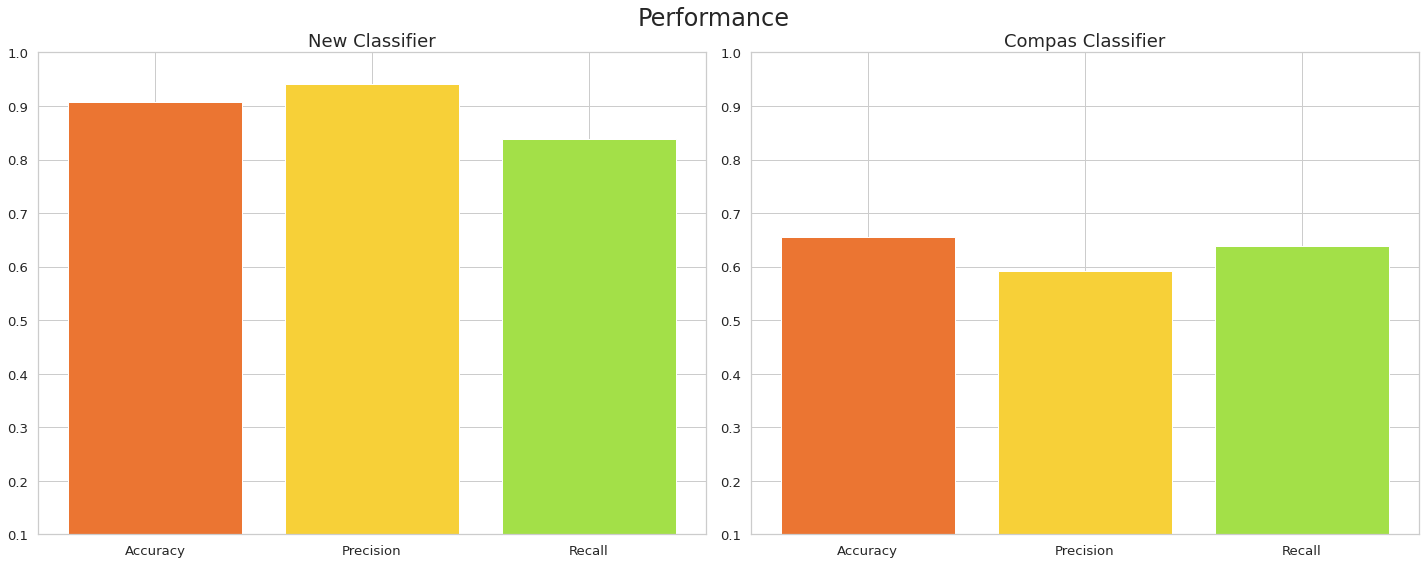

In [134]:
#Performance between fair classifier and compas
plt.rcParams.update({'font.size': 13})
classf = ['Accuracy', 'Precision', 'Recall']
new = [newacc, newpre, newrec]
com = [comacc, compre, comrec]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Performance', fontsize=24)
axes[0].set_title('New Classifier', fontsize=18)
axes[0].bar(classf, new, color=['#eb7532','#f7d038','#a3e048'])
axes[0].set_ylim([0.1,1])
axes[1].set_title('Compas Classifier', fontsize=18)
axes[1].bar(classf, com, color=['#eb7532','#f7d038','#a3e048'])
axes[1].set_ylim([0.1,1])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

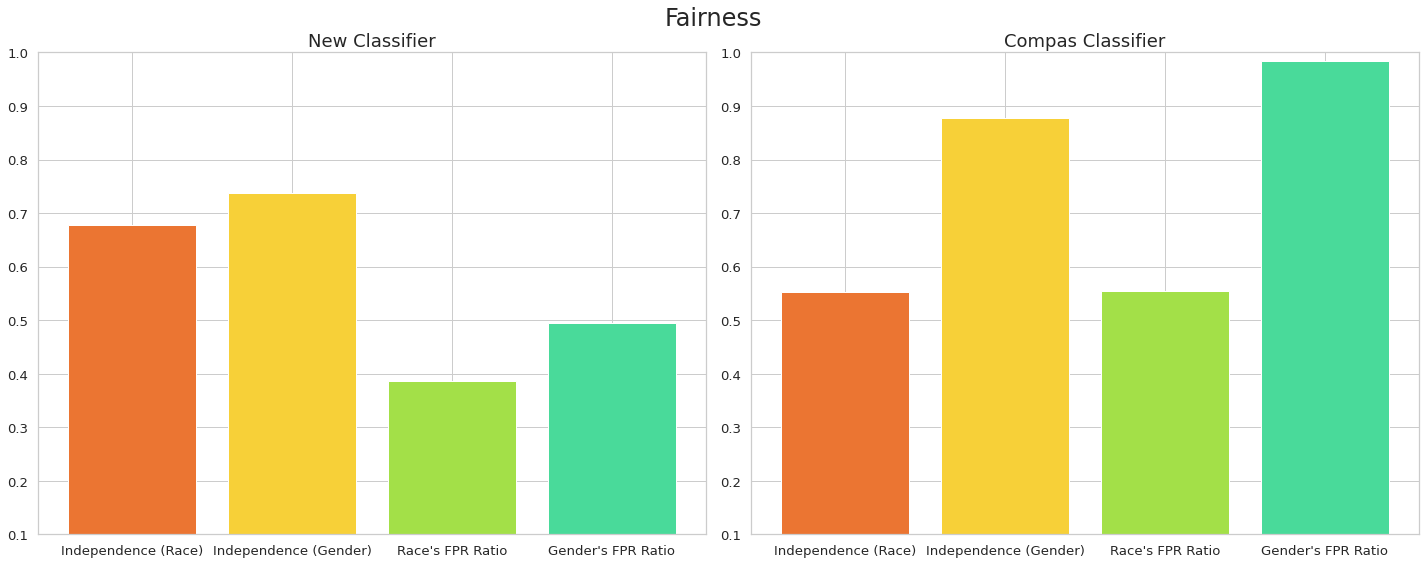

In [135]:
#fairness and FPR by gender and race between fair classifier and compas
classf = ['Independence (Race)', 'Independence (Gender)', 'Race\'s FPR Ratio', 'Gender\'s FPR Ratio']
new = [independence5, independence5g, sepf5r, sepf5g]
com = [independencec, independencecf, sepf5c, sepf5cf]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.suptitle('Fairness', fontsize=24)
axes[0].set_title('New Classifier', fontsize=18)
axes[0].bar(classf, new, color=['#eb7532','#f7d038','#a3e048','#49da9a'])
axes[0].set_ylim([0.1,1])
axes[1].set_title('Compas Classifier', fontsize=18)
axes[1].bar(classf, com, color=['#eb7532','#f7d038','#a3e048','#49da9a'])
axes[1].set_ylim([0.1,1])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

## 3.3 Conclusion
Based on the graphs above we can see that in term of performance our new classifier performs significantly better than compass classifier. However the compas classifier relatively better on fairness. This is an indication that removing the sensitive features does not necessary guarantee the fairness of a classifier.